In [1]:
# fit.py
import argparse
import numpy as np
import nibabel as nib
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as utils
from tqdm import tqdm      
import matplotlib.pyplot as plt      

/Users/paddyslator/python/self-qmri/.venv/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
DATADIR = '/Users/paddyslator/Library/CloudStorage/OneDrive-UniversityCollegeLondon/data/gliomas/CRP_Glioma_DiffT2_EPI/'

imgfilename = 'CRP_Glioma_DiffT2_EPI_GL261_MB1/CRP_Glioma_DiffT2_EPI_GL261_MB1_den_avgData_reordered.nii.gz'
maskfilename = 'CRP_Glioma_DiffT2_EPI_GL261_MB1/CRP_Glioma_DiffT2_EPI_GL261_MB1_rawMask.nii.gz'
#imgfilename = 'CRP_Glioma_DiffT2_EPI_Control1/CRP_Glioma_DiffT2_EPI_Control1_den_avgData_reordered.nii.gz'
#maskfilename = 'CRP_Glioma_DiffT2_EPI_Control1/CRP_Glioma_DiffT2_EPI_Control1_rawMask.nii.gz'

imgfilename = 'CRP_Glioma_DiffT2_EPI_GL261_MB2/CRP_Glioma_DiffT2_EPI_GL261_MB2_den_avgData_reordered.nii.gz'
maskfilename = 'CRP_Glioma_DiffT2_EPI_GL261_MB2/CRP_Glioma_DiffT2_EPI_GL261_MB2_rawMask.nii.gz'

#imgfilename = 'CRP_Glioma_DiffT2_EPI_GL261_MB3/CRP_Glioma_DiffT2_EPI_GL261_MB3_den_avgData_reordered.nii.gz'
#maskfilename = 'CRP_Glioma_DiffT2_EPI_GL261_MB3/CRP_Glioma_DiffT2_EPI_GL261_MB3_rawMask.nii.gz'

gradfilename = 'CRP_Glioma_DiffT2_EPI_Control1/CRP_Glioma_DiffT2_EPI_Control1_den_avgData_gradecho.txt'




imgnii = nib.load(DATADIR + imgfilename)
img = imgnii.get_fdata()

masknii = nib.load(DATADIR + maskfilename)
mask = masknii.get_fdata()

grad = np.loadtxt(DATADIR + gradfilename)

#grad[:,3]=1e-3*grad[:,3]
grad[:,3] = 1e-3*(grad[:,3] - np.min(grad[:,3]))

grad[:,4]=1e-3*grad[:,4]




: 

: 

: 

: 

: 

In [ ]:
# #preprocess data
# from utilities.preprocessing import direction_average

# #take the spherical mean
# da_img,da_grad = direction_average(img,grad)



: 

: 

: 

: 

: 

In [ ]:
#remove anything b>3,500
tokeep = grad[:,3] < 3.5

grad = grad[tokeep,:]
img = img[:,:,:,tokeep]

: 

: 

: 

: 

: 

In [ ]:
#preprocess for machine learning! MAKE A FUNCTION OF THIS!
#(todo)

def img2voxel(img,mask):
    nvoxtotal = np.prod(np.shape(img)[0:3])
    nvol = np.shape(img)[3]
    #image in voxel format
    imgvox = np.reshape(img,(nvoxtotal,nvol))
    #mask in voxel format
    maskvox = np.reshape(mask,(nvoxtotal))
    #extract the voxels in the mask
    X_train = imgvox[maskvox==1]    
    
    return X_train,maskvox


X_train,maskvox = img2voxel(img,mask)

nvoxtotal = np.prod(np.shape(img)[0:3])
nvol = np.shape(img)[3]
#image in voxel format
imgvox = np.reshape(img,(nvoxtotal,nvol))
#mask in voxel format
maskvox = np.reshape(mask,(nvoxtotal))
#extract the voxels in the mask
X_train = imgvox[maskvox==1]

def normalise(X_train,grad):
    nvol = np.shape(grad)[0]
    
    #normalise 
    #find the volumes to normalise by - the lowest b-value lowest TE volume
    #ADD SOME TOLERANCE TO THIS
    #normvol = np.where((grad[:,3] == min(grad[:,3])) & (grad[:,4]==min(grad[:,4])))
    normvol=[0]
    if len(normvol)>1:
        X_train = X_train/(np.tile(np.mean(X_train[:,normvol], axis=1),(1, nvol)))
    else:
        X_train = X_train/(np.tile(X_train[:,normvol],(1, nvol)))
    
    return X_train


X_train = normalise(X_train,grad)
    

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

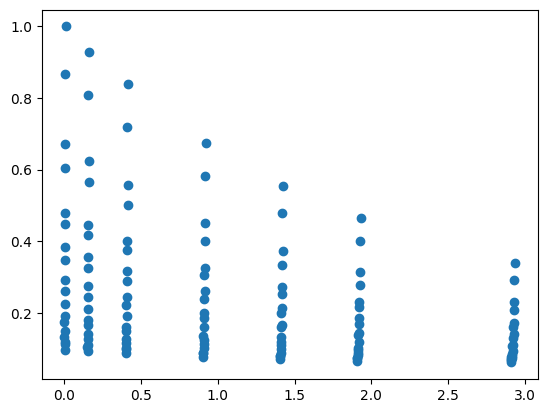

: 

: 

: 

: 

: 

In [ ]:
plt.plot(grad[:,3],X_train[20,:],'o')

In [ ]:
nparams = 3
#define the neural network - change to import this from elsewhere! 
class Net(nn.Module):
    def __init__(self, grad, nparams): #PASS MODEL STRING AS AN ARGUMENT IN HERE!
        super(Net, self).__init__()

        self.grad = grad
        self.fc_layers = nn.ModuleList()
        
        for i in range(nparams): # 3 fully connected hidden layers
            self.fc_layers.extend([nn.Linear(grad.size(0), grad.size(0)), nn.ReLU()])
        self.encoder = nn.Sequential(*self.fc_layers, nn.Linear(grad.size(0), nparams))
        #self.dropout = nn.Dropout(0.5)

    def forward(self, X):
        #X = self.dropout(X)
        params = torch.abs(self.encoder(X)) # D, T2, K
        D = torch.clamp(params[:, 0].unsqueeze(1), min = 0.01, max = 5)
        T2 = torch.clamp(params[:, 1].unsqueeze(1), min=0.01, max=3)
        K = torch.clamp(params[:, 2].unsqueeze(1), min=0.001, max=3)
        #T2 = params[:, 1].unsqueeze(1)
        #K = params[:, 2].unsqueeze(1)
        #D = params[:, 0].unsqueeze(1)
        bvals = self.grad[:,3]
        TE = self.grad[:,4]
        
        #X = torch.exp(-bvals*D + (bvals**2 * D**2 * K / 6)) * torch.exp(-TE/T2) 
        X = torch.exp(-bvals*D + (bvals**2 * D**2 * K / 6)) * torch.exp(-(TE - torch.min(TE))/T2) 



        #X = torch.exp(-bvals*D + (bvals**2 * D**2 * K / 6)) 
        

        
        return X, D, T2, K


: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

In [ ]:

# make the Network
grad = torch.FloatTensor(grad)
net = Net(grad, nparams)

# Loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr = 0.0001)  
#optimizer = optim.SGD(net.parameters(), lr = 0.01)  


#create batch queues
batch_size = 128
num_batches = len(X_train) // batch_size

#X_train = X_train[:,1:] # exlude the b=0 value as signals are normalized

trainloader = utils.DataLoader(torch.from_numpy(X_train.astype(np.float32)),
                            batch_size = batch_size, 
                            shuffle = True,
                            num_workers = 2,
                            drop_last = True)


: 

: 

: 

: 

: 

In [ ]:
# Best loss
best = 1e16
num_bad_epochs = 0
patience = 10

                
# Train
for epoch in range(100): 
    print("-----------------------------------------------------------------")
    print("Epoch: {}; Bad epochs: {}".format(epoch, num_bad_epochs))
    net.train()
    running_loss = 0.

    for i, X_batch in enumerate(tqdm(trainloader), 0):
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        #X_pred, Dp_pred, Dt_pred, Fp_pred = net(X_batch)
        X_pred, D_pred, T2_pred, K_pred = net(X_batch)
        loss = criterion(X_pred, X_batch)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    
    print("Loss: {}".format(running_loss))
    # early stopping
    if running_loss < best:
        print("############### Saving good model ###############################")
        final_model = net.state_dict()
        best = running_loss
        num_bad_epochs = 0
    else:
        num_bad_epochs = num_bad_epochs + 1
        if num_bad_epochs == patience:
            print("Done, best loss: {}".format(best))
            break
print("Done")
# Restore best model
net.load_state_dict(final_model)

-----------------------------------------------------------------
Epoch: 0; Bad epochs: 0


100%|██████████| 454/454 [00:01<00:00, 335.22it/s]


Loss: 3.130228458554484
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 1; Bad epochs: 0


100%|██████████| 454/454 [00:01<00:00, 339.58it/s]


Loss: 0.4807112759735901
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 2; Bad epochs: 0


100%|██████████| 454/454 [00:01<00:00, 337.84it/s]


Loss: 0.2582411131297704
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 3; Bad epochs: 0


100%|██████████| 454/454 [00:01<00:00, 326.99it/s]


Loss: 0.23049989134597126
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 4; Bad epochs: 0


100%|██████████| 454/454 [00:01<00:00, 326.80it/s]


Loss: 0.2172076408751309
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 5; Bad epochs: 0


100%|██████████| 454/454 [00:01<00:00, 329.15it/s]


Loss: 0.20627036788209807
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 6; Bad epochs: 0


100%|██████████| 454/454 [00:01<00:00, 332.42it/s]


Loss: 0.2038148273859406
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 7; Bad epochs: 0


100%|██████████| 454/454 [00:01<00:00, 331.31it/s]


Loss: 0.20082094303506892
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 8; Bad epochs: 0


100%|██████████| 454/454 [00:01<00:00, 344.67it/s]


Loss: 0.20009729496086948
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 9; Bad epochs: 0


100%|██████████| 454/454 [00:01<00:00, 334.08it/s]


Loss: 0.1973892623791471
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 10; Bad epochs: 0


100%|██████████| 454/454 [00:01<00:00, 328.35it/s]


Loss: 0.19679636249202304
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 11; Bad epochs: 0


100%|██████████| 454/454 [00:01<00:00, 336.31it/s]


Loss: 0.19815919478423893
-----------------------------------------------------------------
Epoch: 12; Bad epochs: 1


100%|██████████| 454/454 [00:01<00:00, 334.64it/s]


Loss: 0.19842015304311644
-----------------------------------------------------------------
Epoch: 13; Bad epochs: 2


100%|██████████| 454/454 [00:01<00:00, 337.85it/s]


Loss: 0.19623660406796262
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 14; Bad epochs: 0


100%|██████████| 454/454 [00:01<00:00, 325.11it/s]


Loss: 0.19588066545838956
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 15; Bad epochs: 0


100%|██████████| 454/454 [00:01<00:00, 334.70it/s]


Loss: 0.194968187410268
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 16; Bad epochs: 0


100%|██████████| 454/454 [00:01<00:00, 334.86it/s]


Loss: 0.19432710477849469
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 17; Bad epochs: 0


100%|██████████| 454/454 [00:01<00:00, 331.35it/s]


Loss: 0.1959703196771443
-----------------------------------------------------------------
Epoch: 18; Bad epochs: 1


100%|██████████| 454/454 [00:01<00:00, 328.83it/s]


Loss: 0.19322567607741803
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 19; Bad epochs: 0


100%|██████████| 454/454 [00:01<00:00, 312.35it/s]


Loss: 0.19236369295686018
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 20; Bad epochs: 0


100%|██████████| 454/454 [00:01<00:00, 321.81it/s]


Loss: 0.19408612334518693
-----------------------------------------------------------------
Epoch: 21; Bad epochs: 1


100%|██████████| 454/454 [00:01<00:00, 326.83it/s]


Loss: 0.19318369691609405
-----------------------------------------------------------------
Epoch: 22; Bad epochs: 2


100%|██████████| 454/454 [00:01<00:00, 319.28it/s]


Loss: 0.19238806146313436
-----------------------------------------------------------------
Epoch: 23; Bad epochs: 3


100%|██████████| 454/454 [00:01<00:00, 327.23it/s]


Loss: 0.19171340482716914
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 24; Bad epochs: 0


100%|██████████| 454/454 [00:01<00:00, 325.52it/s]


Loss: 0.19166720734210685
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 25; Bad epochs: 0


100%|██████████| 454/454 [00:01<00:00, 328.02it/s]


Loss: 0.19137512102315668
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 26; Bad epochs: 0


100%|██████████| 454/454 [00:01<00:00, 327.70it/s]


Loss: 0.190002819232177
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 27; Bad epochs: 0


100%|██████████| 454/454 [00:01<00:00, 309.53it/s]


Loss: 0.1908869170001708
-----------------------------------------------------------------
Epoch: 28; Bad epochs: 1


100%|██████████| 454/454 [00:01<00:00, 334.03it/s]


Loss: 0.18951317059691064
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 29; Bad epochs: 0


100%|██████████| 454/454 [00:01<00:00, 327.07it/s]


Loss: 0.1898518827947555
-----------------------------------------------------------------
Epoch: 30; Bad epochs: 1


100%|██████████| 454/454 [00:01<00:00, 316.77it/s]


Loss: 0.18811466818442568
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 31; Bad epochs: 0


100%|██████████| 454/454 [00:01<00:00, 329.39it/s]


Loss: 0.18836444278713316
-----------------------------------------------------------------
Epoch: 32; Bad epochs: 1


100%|██████████| 454/454 [00:01<00:00, 335.85it/s]


Loss: 0.18923631751385983
-----------------------------------------------------------------
Epoch: 33; Bad epochs: 2


100%|██████████| 454/454 [00:01<00:00, 346.06it/s]


Loss: 0.18753864566679113
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 34; Bad epochs: 0


100%|██████████| 454/454 [00:01<00:00, 323.01it/s]


Loss: 0.18722859225817956
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 35; Bad epochs: 0


100%|██████████| 454/454 [00:01<00:00, 339.80it/s]


Loss: 0.18680205011332873
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 36; Bad epochs: 0


100%|██████████| 454/454 [00:01<00:00, 331.21it/s]


Loss: 0.18700258395983838
-----------------------------------------------------------------
Epoch: 37; Bad epochs: 1


100%|██████████| 454/454 [00:01<00:00, 331.71it/s]


Loss: 0.18645808461587876
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 38; Bad epochs: 0


100%|██████████| 454/454 [00:01<00:00, 329.97it/s]


Loss: 0.18625521195644978
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 39; Bad epochs: 0


100%|██████████| 454/454 [00:01<00:00, 326.72it/s]


Loss: 0.18608417645737063
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 40; Bad epochs: 0


100%|██████████| 454/454 [00:01<00:00, 319.90it/s]


Loss: 0.1855581694690045
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 41; Bad epochs: 0


100%|██████████| 454/454 [00:01<00:00, 341.42it/s]


Loss: 0.18535398079256993
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 42; Bad epochs: 0


100%|██████████| 454/454 [00:01<00:00, 330.64it/s]


Loss: 0.18481506122043356
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 43; Bad epochs: 0


100%|██████████| 454/454 [00:01<00:00, 296.37it/s]


Loss: 0.18437658215407282
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 44; Bad epochs: 0


100%|██████████| 454/454 [00:01<00:00, 305.32it/s]


Loss: 0.18391257686016615
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 45; Bad epochs: 0


100%|██████████| 454/454 [00:01<00:00, 248.28it/s]


Loss: 0.18369621750025544
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 46; Bad epochs: 0


100%|██████████| 454/454 [00:01<00:00, 306.23it/s]


Loss: 0.1829761985281948
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 47; Bad epochs: 0


100%|██████████| 454/454 [00:01<00:00, 303.37it/s]


Loss: 0.18196361273294315
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 48; Bad epochs: 0


100%|██████████| 454/454 [00:02<00:00, 193.37it/s]


Loss: 0.1836953732999973
-----------------------------------------------------------------
Epoch: 49; Bad epochs: 1


100%|██████████| 454/454 [00:03<00:00, 148.35it/s]


Loss: 0.18151741595647763
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 50; Bad epochs: 0


100%|██████████| 454/454 [00:02<00:00, 220.97it/s]


Loss: 0.18154188139305916
-----------------------------------------------------------------
Epoch: 51; Bad epochs: 1


100%|██████████| 454/454 [00:01<00:00, 240.96it/s]


Loss: 0.18198189156828448
-----------------------------------------------------------------
Epoch: 52; Bad epochs: 2


100%|██████████| 454/454 [00:01<00:00, 231.51it/s]


Loss: 0.18258047457493376
-----------------------------------------------------------------
Epoch: 53; Bad epochs: 3


100%|██████████| 454/454 [00:02<00:00, 216.75it/s]


Loss: 0.18093586516624782
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 54; Bad epochs: 0


100%|██████████| 454/454 [00:02<00:00, 221.91it/s]


Loss: 0.18126704294991214
-----------------------------------------------------------------
Epoch: 55; Bad epochs: 1


100%|██████████| 454/454 [00:01<00:00, 267.51it/s]


Loss: 0.18043525698885787
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 56; Bad epochs: 0


100%|██████████| 454/454 [00:01<00:00, 258.71it/s]


Loss: 0.18077594714122824
-----------------------------------------------------------------
Epoch: 57; Bad epochs: 1


100%|██████████| 454/454 [00:01<00:00, 257.49it/s]


Loss: 0.1809282737231115
-----------------------------------------------------------------
Epoch: 58; Bad epochs: 2


100%|██████████| 454/454 [00:01<00:00, 236.84it/s]


Loss: 0.18022106697026175
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 59; Bad epochs: 0


100%|██████████| 454/454 [00:01<00:00, 245.08it/s]


Loss: 0.17979312471288722
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 60; Bad epochs: 0


100%|██████████| 454/454 [00:01<00:00, 267.86it/s]


Loss: 0.17958797633764334
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 61; Bad epochs: 0


100%|██████████| 454/454 [00:02<00:00, 203.64it/s]


Loss: 0.1803433472668985
-----------------------------------------------------------------
Epoch: 62; Bad epochs: 1


100%|██████████| 454/454 [00:05<00:00, 89.94it/s] 


Loss: 0.18029474302602466
-----------------------------------------------------------------
Epoch: 63; Bad epochs: 2


100%|██████████| 454/454 [00:10<00:00, 42.64it/s] 


Loss: 0.17886926591745578
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 64; Bad epochs: 0


100%|██████████| 454/454 [00:08<00:00, 51.25it/s] 


Loss: 0.179598233095021
-----------------------------------------------------------------
Epoch: 65; Bad epochs: 1


100%|██████████| 454/454 [00:06<00:00, 73.27it/s] 


Loss: 0.17886948588420637
-----------------------------------------------------------------
Epoch: 66; Bad epochs: 2


100%|██████████| 454/454 [00:05<00:00, 79.72it/s] 


Loss: 0.17910201199993026
-----------------------------------------------------------------
Epoch: 67; Bad epochs: 3


100%|██████████| 454/454 [00:05<00:00, 79.91it/s] 


Loss: 0.1800962887937203
-----------------------------------------------------------------
Epoch: 68; Bad epochs: 4


100%|██████████| 454/454 [00:05<00:00, 85.64it/s] 


Loss: 0.1790394485433353
-----------------------------------------------------------------
Epoch: 69; Bad epochs: 5


100%|██████████| 454/454 [00:06<00:00, 70.57it/s] 


Loss: 0.17839444853598252
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 70; Bad epochs: 0


100%|██████████| 454/454 [00:06<00:00, 69.08it/s] 


Loss: 0.1783086787472712
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 71; Bad epochs: 0


100%|██████████| 454/454 [00:12<00:00, 35.40it/s] 


Loss: 0.17926984040241223
-----------------------------------------------------------------
Epoch: 72; Bad epochs: 1


100%|██████████| 454/454 [00:06<00:00, 68.00it/s] 


Loss: 0.17952684964984655
-----------------------------------------------------------------
Epoch: 73; Bad epochs: 2


100%|██████████| 454/454 [00:08<00:00, 52.50it/s] 


Loss: 0.1779467070591636
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 74; Bad epochs: 0


100%|██████████| 454/454 [00:05<00:00, 83.47it/s] 


Loss: 0.17851502112171147
-----------------------------------------------------------------
Epoch: 75; Bad epochs: 1


100%|██████████| 454/454 [00:04<00:00, 91.59it/s] 


Loss: 0.17813899894827046
-----------------------------------------------------------------
Epoch: 76; Bad epochs: 2


100%|██████████| 454/454 [00:04<00:00, 109.42it/s]


Loss: 0.17860911383468192
-----------------------------------------------------------------
Epoch: 77; Bad epochs: 3


100%|██████████| 454/454 [00:04<00:00, 96.40it/s] 


Loss: 0.17917943168140482
-----------------------------------------------------------------
Epoch: 78; Bad epochs: 4


100%|██████████| 454/454 [00:04<00:00, 102.56it/s]


Loss: 0.17965813011687715
-----------------------------------------------------------------
Epoch: 79; Bad epochs: 5


100%|██████████| 454/454 [00:05<00:00, 81.75it/s] 


Loss: 0.17835898960765917
-----------------------------------------------------------------
Epoch: 80; Bad epochs: 6


100%|██████████| 454/454 [00:04<00:00, 93.48it/s] 


Loss: 0.17804866301594302
-----------------------------------------------------------------
Epoch: 81; Bad epochs: 7


100%|██████████| 454/454 [00:05<00:00, 79.73it/s] 


Loss: 0.1783150998817291
-----------------------------------------------------------------
Epoch: 82; Bad epochs: 8


100%|██████████| 454/454 [00:05<00:00, 87.49it/s] 


Loss: 0.17748896176635753
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 83; Bad epochs: 0


100%|██████████| 454/454 [00:05<00:00, 88.00it/s] 


Loss: 0.17793095132219605
-----------------------------------------------------------------
Epoch: 84; Bad epochs: 1


100%|██████████| 454/454 [00:05<00:00, 80.35it/s] 


Loss: 0.17766571787069552
-----------------------------------------------------------------
Epoch: 85; Bad epochs: 2


100%|██████████| 454/454 [00:04<00:00, 90.88it/s] 


Loss: 0.17755177782964893
-----------------------------------------------------------------
Epoch: 86; Bad epochs: 3


100%|██████████| 454/454 [00:05<00:00, 89.82it/s] 


Loss: 0.17846141918562353
-----------------------------------------------------------------
Epoch: 87; Bad epochs: 4


100%|██████████| 454/454 [00:05<00:00, 89.47it/s] 


Loss: 0.17737314457190223
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 88; Bad epochs: 0


100%|██████████| 454/454 [00:04<00:00, 91.85it/s] 


Loss: 0.17764588468708098
-----------------------------------------------------------------
Epoch: 89; Bad epochs: 1


100%|██████████| 454/454 [00:05<00:00, 90.12it/s] 


Loss: 0.17739827001059894
-----------------------------------------------------------------
Epoch: 90; Bad epochs: 2


100%|██████████| 454/454 [00:05<00:00, 89.14it/s] 


Loss: 0.17661022284300998
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 91; Bad epochs: 0


100%|██████████| 454/454 [00:05<00:00, 82.45it/s] 


Loss: 0.17893130153242964
-----------------------------------------------------------------
Epoch: 92; Bad epochs: 1


100%|██████████| 454/454 [00:05<00:00, 89.08it/s] 


Loss: 0.17858968643122353
-----------------------------------------------------------------
Epoch: 93; Bad epochs: 2


100%|██████████| 454/454 [00:04<00:00, 104.28it/s]


Loss: 0.176994122331962
-----------------------------------------------------------------
Epoch: 94; Bad epochs: 3


100%|██████████| 454/454 [00:05<00:00, 89.37it/s] 


Loss: 0.17774617447867058
-----------------------------------------------------------------
Epoch: 95; Bad epochs: 4


100%|██████████| 454/454 [00:05<00:00, 90.45it/s] 


Loss: 0.17665888006740715
-----------------------------------------------------------------
Epoch: 96; Bad epochs: 5


100%|██████████| 454/454 [00:05<00:00, 86.55it/s] 


Loss: 0.1772040192154236
-----------------------------------------------------------------
Epoch: 97; Bad epochs: 6


100%|██████████| 454/454 [00:06<00:00, 72.49it/s] 


Loss: 0.17747235429123975
-----------------------------------------------------------------
Epoch: 98; Bad epochs: 7


100%|██████████| 454/454 [00:05<00:00, 81.82it/s] 


Loss: 0.17745044046023395
-----------------------------------------------------------------
Epoch: 99; Bad epochs: 8


100%|██████████| 454/454 [00:05<00:00, 90.04it/s] 

Loss: 0.17696932109538466
Done


<All keys matched successfully>

: 

: 

: 

: 

: 

In [ ]:
#Inference
net.eval()
with torch.no_grad():
    X, D, T2, K = net(torch.from_numpy(X_train.astype(np.float32)))
    
D = D.numpy()
T2 = T2.numpy()
K = K.numpy()


#convert parameters back to image format
D_vox = np.zeros(np.shape(maskvox))
D_vox[maskvox==1] = np.squeeze(D[:])
D_map = np.reshape(D_vox,np.shape(mask))

T2_vox = np.zeros(np.shape(maskvox))
T2_vox[maskvox==1] = np.squeeze(T2[:])
T2_map = np.reshape(T2_vox,np.shape(mask))

K_vox = np.zeros(np.shape(maskvox))
K_vox[maskvox==1] = np.squeeze(K[:])
K_map = np.reshape(K_vox,np.shape(mask))


: 

: 

: 

: 

: 

In [ ]:
#rotate images
from scipy import ndimage

D_map = ndimage.rotate(D_map,-90,reshape=True)
T2_map = ndimage.rotate(T2_map,-90,reshape=True)
K_map = ndimage.rotate(K_map,-90,reshape=True)



: 

: 

: 

: 

: 

(-0.5, 103.5, 93.5, -0.5)

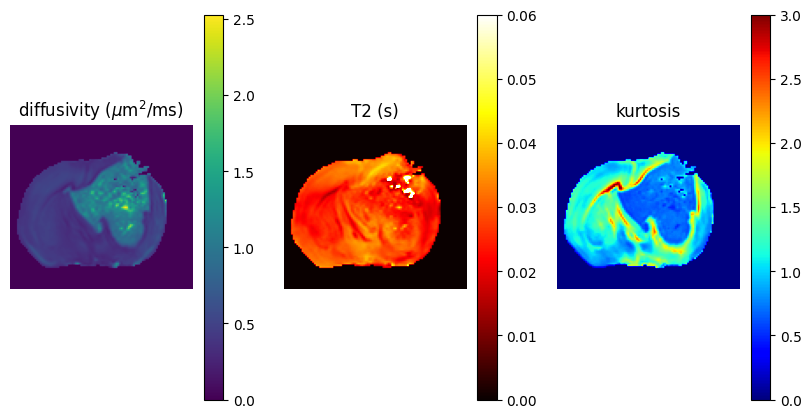

: 

: 

: 

: 

: 

In [ ]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 3, figsize=(10,5))

zslice=5

plt0 = ax[0].imshow(D_map[:,:,zslice])
plt.colorbar(plt0,ax=ax[0])
ax[0].xaxis.set_ticklabels([]) 
ax[0].set_title('diffusivity ($\mu$m$^2$/ms)')
#ax[0].set_title('diffusivity (mm$^2$/ms)')
ax[0].axis('off')

plt0 = ax[1].imshow(T2_map[:,:,zslice],cmap='hot',vmin=0,vmax=.06)
plt.colorbar(plt0,ax=ax[1])    
ax[1].xaxis.set_ticklabels([]) 
ax[1].set_title('T2 (s)')
ax[1].axis('off')
    
plt0 = ax[2].imshow(K_map[:,:,zslice],cmap='jet')
plt.colorbar(plt0,ax=ax[2])    
ax[2].xaxis.set_ticklabels([]) 
ax[2].set_title('kurtosis')
ax[2].axis('off')    
    

In [ ]:
#save the inferred maps as niftis
maps = np.stack((D_map, T2_map, K_map),axis=-1)

#use the image as a template
mapsnii = nib.Nifti1Image(maps, affine=imgnii.affine,header=imgnii.header)
#adjust 4th spatial dimension
mapsnii.header['dim'][4] = np.shape(maps)[-1]

nib.save(mapsnii, DATADIR + imgfilename[0:-7] + '_DT2K_maps.nii.gz')  

: 

: 

: 

: 

: 

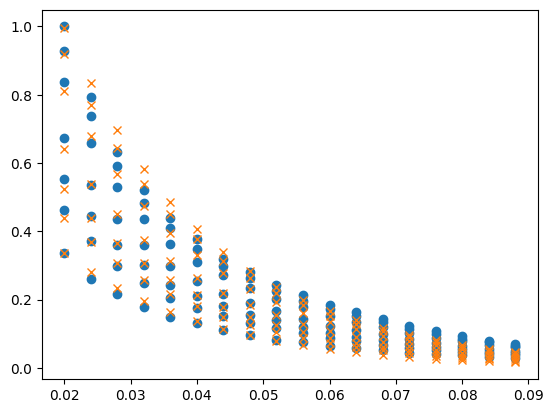

: 

: 

: 

: 

: 

In [ ]:
plt.plot(grad[:,4],X_train[2500,:],'o')
plt.plot(grad[:,4],X[2500,:],'x')

In [ ]:
criterion(X_pred, X_batch)

tensor(0.0002, grad_fn=<MseLossBackward0>)

: 

: 

: 

: 

: 

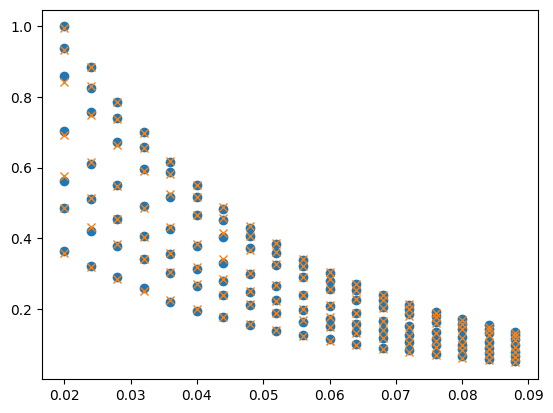

: 

: 

: 

: 

: 

In [ ]:
plt.plot(grad[:,4],X_batch[10,:].detach().numpy(),'o')
plt.plot(grad[:,4],X_pred[10,:].detach().numpy(),'x')

In [ ]:
torch.min(grad[:,4])

tensor(0.0200)

: 

: 

: 

: 

: 

In [ ]:
grad[:,4]

tensor([0.0200, 0.0200, 0.0200, 0.0200, 0.0200, 0.0200, 0.0200, 0.0240, 0.0240,
        0.0240, 0.0240, 0.0240, 0.0240, 0.0240, 0.0280, 0.0280, 0.0280, 0.0280,
        0.0280, 0.0280, 0.0280, 0.0320, 0.0320, 0.0320, 0.0320, 0.0320, 0.0320,
        0.0320, 0.0360, 0.0360, 0.0360, 0.0360, 0.0360, 0.0360, 0.0360, 0.0400,
        0.0400, 0.0400, 0.0400, 0.0400, 0.0400, 0.0400, 0.0440, 0.0440, 0.0440,
        0.0440, 0.0440, 0.0440, 0.0440, 0.0480, 0.0480, 0.0480, 0.0480, 0.0480,
        0.0480, 0.0480, 0.0520, 0.0520, 0.0520, 0.0520, 0.0520, 0.0520, 0.0520,
        0.0560, 0.0560, 0.0560, 0.0560, 0.0560, 0.0560, 0.0560, 0.0600, 0.0600,
        0.0600, 0.0600, 0.0600, 0.0600, 0.0600, 0.0640, 0.0640, 0.0640, 0.0640,
        0.0640, 0.0640, 0.0640, 0.0680, 0.0680, 0.0680, 0.0680, 0.0680, 0.0680,
        0.0680, 0.0720, 0.0720, 0.0720, 0.0720, 0.0720, 0.0720, 0.0720, 0.0760,
        0.0760, 0.0760, 0.0760, 0.0760, 0.0760, 0.0760, 0.0800, 0.0800, 0.0800,
        0.0800, 0.0800, 0.0800, 0.0800, 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 